## Read data

In [17]:
%env GEOMSTATS_BACKEND=autograd

import matplotlib.pyplot as plt
#from sasaki_metric import SasakiMetric
from geomstats.learning.frechet_mean import FrechetMean
#from geomstats.learning.pca import TangentPCA
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.geometry.discrete_curves import L2CurvesMetric
import numpy as np
from util import N_SUBJ, N_SAMPLES, get_label, get_CatName, visTPCA, colors, legend_handle

# Import resampled trajectories
data = np.load('datasets/hur_resampled.npz', allow_pickle=True)
subj, seq = data['subj'], data['seq']
n_subject = len(subj)
n_samples = subj[0, 2]
trjs = seq[:, 7:10].reshape(n_subject, n_samples, 3)

# load max-wind
data = np.load('datasets/hur.npz', allow_pickle=True)
seq, ids = data['seq'], data['ids']
maxwind = [seq[s:e, 5].max() for s, e in zip(ids[:-1], ids[1:])]

# category label for classification
y = np.array([0 if w < 64 else (1 if w < 113 else 2) for w in maxwind])
np.bincount(y)

env: GEOMSTATS_BACKEND=autograd
mpl_toolkits not available


array([124,  69,  25])

## Run PGA

In [18]:
# Prepare Riemannian structure
l2_metric = L2CurvesMetric(Hypersphere(2))
trj_metric = l2_metric
#trj_metric = srv_metric

# compute mean
ini_mean = np.mean(trjs, axis=0)
ini_mean /= np.linalg.norm(ini_mean, axis=1)[:, None]
mean_gs = FrechetMean(trj_metric, point_type='matrix', init_point=ini_mean)
mean_gs.fit(trjs)
mean_trj = mean_gs.estimate_

# compute tangent PCA
vecs = np.zeros((n_subject, n_samples*3))
for i in range(n_subject):
    vecs[i] = l2_metric.log(trjs[i], base_point=mean_trj).reshape(-1)

# hierarch. dim.-reduction via SVD
U, S, Vt = np.linalg.svd(vecs)
d = np.sum(S > (1e-6 * S.max()))
x = U[:, :d] @ np.diag(S[:d])

## Plot scores

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


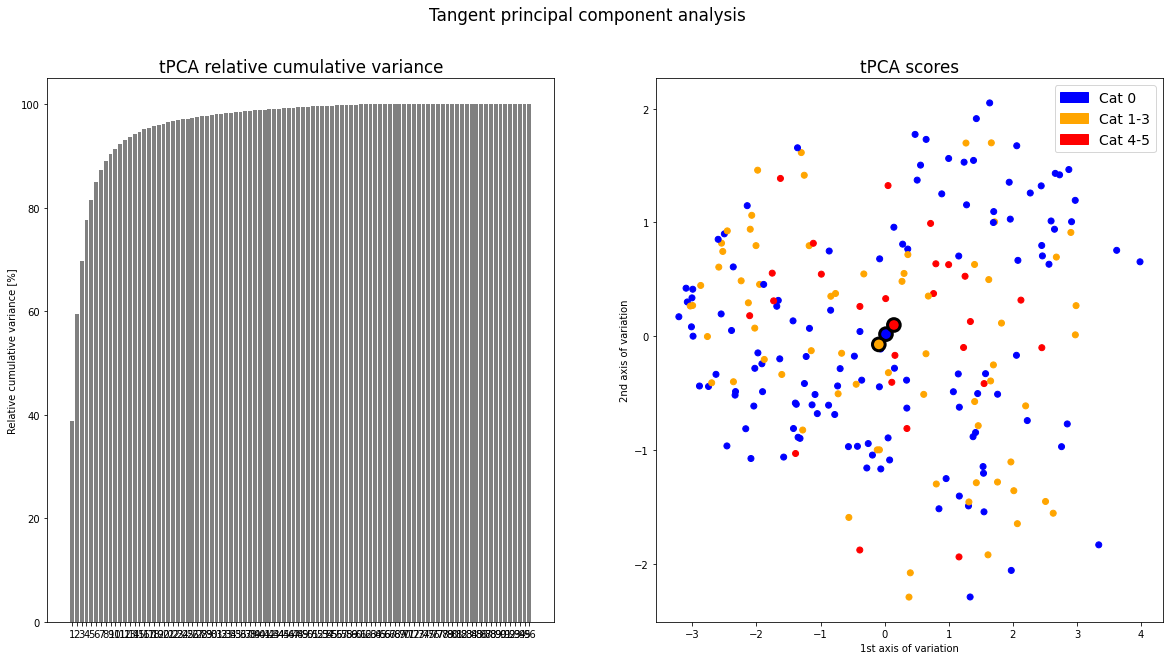

In [19]:
lbl = np.array([colors[y[i]] for i in range(len(y))])
cen_0 = np.mean(x[np.where(y==0)[0]], axis=0)
cen_1 = np.mean(x[np.where(y==1)[0]], axis=0)
cen_2 = np.mean(x[np.where(y==2)[0]], axis=0)
centroids = np.array([cen_0, cen_1, cen_2])
#plt.scatter(*pga.coeffs[:,:2].T, c=lbl)
#plt.show()
visTPCA(S, x, lbl, dim3=False, legend_handles=legend_handle, colors=colors, txt=False, centroids=centroids)

## Classify

In [23]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score as bas
from sklearn.utils.fixes import loguniform

# k-fold stratified cross-validation
k_fold = 3
skf = StratifiedKFold(k_fold, shuffle=True)

# features
# x /= np.linalg.norm(x, axis=1)[:, None]

# SVM
acc = []
for n in range(1000):
    for train_index, test_index in skf.split(x, y):
        # train classifier
        svc = SVC(kernel='rbf', gamma=.7, C=3, class_weight='balanced')
        svc.fit(x[train_index], y[train_index])
        # test
        train_acc, test_acc = bas(y[train_index], svc.predict(x[train_index])), bas(y[test_index], svc.predict(x[test_index]))
        acc += [test_acc] # / k_fold # skf.get_n_splits()
acc = np.array(acc)
print('Average Test Acc: {:.5f}({:.5f})'.format(acc.mean(), acc.std()))

# np.save('figures/acc_l2.npy', acc)

Average Test Acc: 0.49104(0.06035)
